In this notebook we will practice how to load and preprocess data using tensorflow's data API. 

Also, see the following official [guide](https://www.tensorflow.org/guide/data#basic_mechanics)

## Excercise 1

This is excercise 13.9 in [this](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) book: 

### Problem statement:

Load the Fashion MNIST dataset; split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized Example protobuf with two features: the serialized image (use tf.io.serialize_tensor() to serialize each image), and the label. Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.

In [1]:
import tensorflow as tf
from tensorflow import keras
print('tensorflow version:{}'.format(tf.__version__))
print('keras version: {}'.format(keras.__version__))

import numpy as np

tensorflow version:2.1.0
keras version: 2.2.4-tf


In [2]:
# import fashion-MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist 
# the above is the fashion_mnist module
# call fashion_mnist.load_data() to download the data using the above module
# fashion_mnist.load_data returns one tuple of training images and their labels, and another tuple of test images and their labels
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
print('number of images in training set: {}'.format(len(X_train_full)))
print('number of images in test set: {}'.format(len(X_test)))

number of images in training set: 60000
number of images in test set: 10000


In [4]:
# the images are stored as numpy arrays
print('X_train_full is of type: {}'.format(type(X_train_full)))
print('y_train_full is of type: {}'.format(type(y_train_full)))

X_train_full is of type: <class 'numpy.ndarray'>
y_train_full is of type: <class 'numpy.ndarray'>


In [5]:
print('shape of X_train_full:{}'.format(X_train_full.shape))
print('minimum pixel value: {}'.format(X_train_full.min()))
print('maximum pixel value: {}'.format(X_train_full.max()))

shape of X_train_full:(60000, 28, 28)
minimum pixel value: 0
maximum pixel value: 255


In [6]:
# split X_train_full into a training set and a validation set
num_val = 10000 # number of instances in validation set
X_val, X_train = X_train_full[:num_val], X_train_full[num_val:]
y_val, y_train = y_train_full[:num_val], y_train_full[num_val:]

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", 
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [8]:
import matplotlib.pyplot as plt

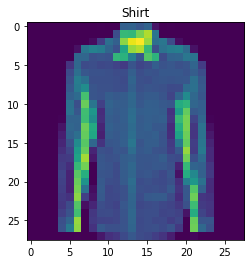

In [9]:
idx = 90
plt.figure()
plt.imshow(X_train[idx]/255.0)
plt.title(class_names[y_train[idx]])
plt.show()

In [10]:
# create tensorflow datasets from training, validation and test images
train_imgs = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_imgs = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_imgs = tf.data.Dataset.from_tensor_slices((X_test, y_test))
print('specs of train_imgs: {}'.format(train_imgs.element_spec))
print('specs of val_imgs: {}'.format(val_imgs.element_spec))
print('specs of test_imgs: {}'.format(test_imgs.element_spec))

specs of train_imgs: (TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))
specs of val_imgs: (TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))
specs of test_imgs: (TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))


In [11]:
# function to convert an individual record from the dataset into a serialized Example protobuf
def to_Example_protobuf(record):
    '''Convert a record to a serialized Example protobuf. The record is assumed to be a tuple with the first entry being a tensor and the second entry being its label
    '''
    
    # convert the first entry of the record i.e. the image, to a Feature class
    # tensors should be converted to binary strings first
    bin_string = tf.io.serialize_tensor(record[0]).numpy()
    # since it is a string we can only store it as a BytesList but NOT as a FloatList or Int64List
    bytes_list = tf.train.BytesList(value = [bin_string]) # note that the value in BytesList has to be a list
    # convert the above BytesList to a Feature
    img = tf.train.Feature(bytes_list = bytes_list)
    
    # convert the second entry in the record i.e. the image-label to a Feature class
    # note that label are integers, so can be stored as Int64List
    int64_list = tf.train.Int64List(value = [record[1].numpy()])
    lbl = tf.train.Feature(int64_list = int64_list)
    
    # now add img and lbl, as obtained above, to a dictionary 
    # then use it to create an instance of the Features class
    feature = {'img': img, 'lbl': lbl}
    features = tf.train.Features(feature = feature)
    
    # use the features object above, to create an Example
    example = tf.train.Example(features = features)
    
    return example
    

In [12]:
# function to parse an Example protobuf or a serialized string obtained from it
# if batch == True, then the input is assumed to be a batch rather than a single example 
def from_Example_protobuf(example, batch = False):
    ''' function to parse a example protobuf generated from examples in fashion-MNIST dataset. The input can be an Example protobuf or a serialized string obtained from an Example protobuf The input to this function must be a serialized string '''
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'lbl': tf.io.FixedLenFeature([], tf.int64, default_value = 0)
        }
    
    if batch:
        parsed_examples = tf.io.parse_example(example, feature_description)
        # parsed_examples['img'] is itelf a tensor whose entries are serialized strings corresponding to the images in the batch
        # we therefore need to parse these strings back to tensors using tf.io.parse_tensor
        # This can be applied to the elements of parsed_examples['imgs'] using tf.map_fn
        imgs = tf.map_fn(lambda string: tf.io.parse_tensor(string, out_type = tf.uint8), 
                         parsed_examples['img'], 
                         dtype = tf.uint8) # since the type of output of the tf.map_fn is different from it's input type, we necessarily have to specify the dtype of the output
        lbls = tf.dtypes.cast(parsed_examples['lbl'], tf.uint8)
        return imgs, lbls
    
    if type(example)== bytes:
        parsed_example = tf.io.parse_single_example(example, feature_description)
        img = tf.io.parse_tensor(parsed_example['img'].numpy(), out_type = tf.uint8)
        lbl = tf.dtypes.cast(parsed_example['lbl'],  tf.uint8)
    
    elif str(type(example)) == "<class 'tensorflow.core.example.example_pb2.Example'>":
        img = tf.io.parse_tensor(example.features.feature['img'].bytes_list.value[0], 
                                 out_type = tf.uint8)
        lbl = tf.convert_to_tensor(example.features.feature['lbl'].int64_list.value[0],
                                   dtype = tf.uint8)
    else:
        print('Error: The input is neither a serialized string nor an Example protobuf')
        return
    
    return img, lbl

### Test to_Example_protobuf and from_Example_protobuf

In [13]:
# extract a sample record from train_imgs for testing purposes
for item in train_imgs.take(1):
    train_item = item

In [14]:
# convert the record to Example 
ex = to_Example_protobuf(train_item)

# re-obtain the record from the Example protobuf and check its validity
print('Parsing Example protobuf')
img, lbl = from_Example_protobuf(ex)

# check the validity of img, lbl
print('image data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(img == train_item[0])))
print('label data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(lbl == train_item[1])))

print('Parsing serialized string')
img, lbl = from_Example_protobuf(ex.SerializeToString())

# check the validity of img, lbl
print('image data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(img == train_item[0])))
print('label data was converted to Example and converted back faithfully: {}'.format(tf.math.reduce_all(lbl == train_item[1])))


Parsing Example protobuf
image data was converted to Example and converted back faithfully: True
label data was converted to Example and converted back faithfully: True
Parsing serialized string
image data was converted to Example and converted back faithfully: True
label data was converted to Example and converted back faithfully: True


### Store data in TFRecord files

#### Training set

There are 50000 images in the training set. Let us divide them into 50 TFRecord files with each file containing serialized example protobufs for 1000 images.

In [15]:
# shuffle the training set
seed = 42
buffer_size = 20000
train_shuffled = train_imgs.shuffle(buffer_size = buffer_size, seed = seed)
train_itr = iter(train_shuffled)

In [16]:
train_filepaths = []
compression = tf.io.TFRecordOptions(compression_type = 'GZIP')

for file_num in range(50):
    filename = 'fashion_MNIST_TFRecord/train_tfrecord_'+ str(file_num)+'.tfrecord'
    train_filepaths.append(filename)
    print('\nfile_num: {}'.format(file_num))
    with tf.io.TFRecordWriter(filename, compression) as f:
        for item_num in range(1000):
            train_item = next(train_itr)
            serialized_example = to_Example_protobuf(train_item)
            f.write(serialized_example.SerializeToString())
            if item_num%10 ==0:
                print('*', end = '')


file_num: 0
****************************************************************************************************
file_num: 1
****************************************************************************************************
file_num: 2
****************************************************************************************************
file_num: 3
****************************************************************************************************
file_num: 4
****************************************************************************************************
file_num: 5
****************************************************************************************************
file_num: 6
****************************************************************************************************
file_num: 7
****************************************************************************************************
file_num: 8
***********************************************************************************

#### Validation set

There are 10000 images in the validation set. We will store these in 10 TFRecord files, each containing serialized example protobufs for 1000 images. 

In [17]:
val_filepaths = []
val_itr = iter(val_imgs)

for file_num in range(10):
    filename = 'fashion_MNIST_TFRecord/val_tfrecord_'+ str(file_num) + '.tfrecord'
    val_filepaths.append(filename)
    print('\nfile_num: {}'.format(file_num))
    with tf.io.TFRecordWriter(filename, compression) as f:
        for item_num in range(1000):
            val_item = next(val_itr)
            serialized_example = to_Example_protobuf(val_item)
            f.write(serialized_example.SerializeToString())
            if item_num%10 == 0:
                print('*', end = '')


file_num: 0
****************************************************************************************************
file_num: 1
****************************************************************************************************
file_num: 2
****************************************************************************************************
file_num: 3
****************************************************************************************************
file_num: 4
****************************************************************************************************
file_num: 5
****************************************************************************************************
file_num: 6
****************************************************************************************************
file_num: 7
****************************************************************************************************
file_num: 8
***********************************************************************************

#### Test set

The test set contains 10000 test images. We will create 10 TFRecord files for these, each storing the serialized example protobuf for 1000 images. 

In [18]:
test_filepaths = []
test_itr = iter(test_imgs)

for file_num in range(10):
    filename = 'fashion_MNIST_TFRecord/test_tfrecord_' + str(file_num) + '.tfrecord'
    test_filepaths.append(filename)
    print('\nfile_num: {}'.format(file_num))
    with tf.io.TFRecordWriter(filename, compression) as f:
        for item_num in range(1000):
            test_item = next(test_itr)
            serialized_example = to_Example_protobuf(test_item)
            f.write(serialized_example.SerializeToString())
            if item_num%10==0:
                print('*', end = '')


file_num: 0
****************************************************************************************************
file_num: 1
****************************************************************************************************
file_num: 2
****************************************************************************************************
file_num: 3
****************************************************************************************************
file_num: 4
****************************************************************************************************
file_num: 5
****************************************************************************************************
file_num: 6
****************************************************************************************************
file_num: 7
****************************************************************************************************
file_num: 8
***********************************************************************************

### Create a dataset from the above 

In [32]:
# generically, tf.data.TFRecordDataset accepts a list of filepaths
# in order to specify files using glob patterns rather than a list of filepaths, we do the following
# use tf.data.TFRecordDataset.list_files() to create a filepath_dataset corresponding to a file pattern
# then pass this filepath_dataset to tf.data.TFRecordDataset
train_filepaths = 'fashion_MNIST_TFRecord/train_tfrecord_*.tfrecord'
filepath_dataset = tf.data.TFRecordDataset.list_files(train_filepaths)

batch_size = 5000
num_parallel_reads = 5
train_data = tf.data.TFRecordDataset(filepath_dataset, 
                                     compression_type = 'GZIP',
                                     num_parallel_reads = num_parallel_reads).batch(batch_size)

In [33]:
item = next(iter(train_data.take(1)))

In [34]:
img_batch, lbl_batch = from_Example_protobuf(item, batch = True)

In [35]:
img_batch

<tf.Tensor: shape=(5000, 28, 28), dtype=uint8, numpy=
array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   2,   0, ..., 174,  58,   0],
        ...,
        [  0,   0,   0, ...,  30,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,

In [36]:
lbl_batch

<tf.Tensor: shape=(5000,), dtype=uint8, numpy=array([9, 8, 4, ..., 0, 2, 9], dtype=uint8)>

In [37]:
img_batch.shape

TensorShape([5000, 28, 28])

In [38]:
lbl_batch.shape

TensorShape([5000])